**1) Problem statement**

Data: Sensor Data

Problem statement

- The system in focus is the Air Pressure system (APS) which generates pressurized air that are utilized in various functions in a truck, such as braking and gear changes. The datasets positive class corresponds to component failures for a specific component of the APS system. The negative class corresponds to trucks with failures for components not related to the APS system.

- The problem is to reduce the cost due to unnecessary repairs. So it is required to minimize the false predictions.

- Cost1 = 10 and Cost2 = 500

- The total cost of a prediction model the sum of 'Cost_1' multiplied by the number of Instances with type 1 failure and 'Cost_2' with the number of instances with type 2 failure, resulting in a "Total_cosť. In this case 'Cost_1' refers to the cost that an unnecessary check needs to be done by an mechanic at an workshop, while 'Cost_2' refer to the cost of missing a faulty truck, which may cause a breakdown.

- Total_cost = Cost_1* No_Instances + Cost_2* No_Instances

- From the above problem statement we could observe that, we have to reduce false positives and false negatives. More importantly we have to "reduce fae negatives, since cost incurred due to false negative is 50 times higher than the false positives.

**Challenges and Other Objectives**

- Need to handle many Null values in almost all columns
- No low - latency requirement.
- Interpretability is not important.
- Misclassification leads the unecessary repair cots.

**2) Import required libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import plotly.graph_objects as go

from statistics import mean

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.pipeline import Pipeline
from sklearn.utils import resample

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier , GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer, KNNImputer

from sklearn import metrics

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix


warnings.filterwarnings("ignore")
%matplotlib inline



**Read Data**

In [2]:
df = pd.read_csv(r'Dataset\aps_failure_training_set1.csv', na_values="na")
df

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,pos,153204,0.0,1.820000e+02,NaN,0.0,0.0,0.0,0.0,0.0,...,129862.0,26872.0,34044.0,22472.0,34362.0,0.0,0.0,0.0,0.0,0.0
1,pos,453236,NaN,2.926000e+03,NaN,0.0,0.0,0.0,0.0,222.0,...,7908038.0,3026002.0,5025350.0,2025766.0,1160638.0,533834.0,493800.0,6914.0,0.0,0.0
2,pos,72504,NaN,1.594000e+03,1052.0,0.0,0.0,0.0,244.0,178226.0,...,1432098.0,372252.0,527514.0,358274.0,332818.0,284178.0,3742.0,0.0,0.0,0.0
3,pos,762958,NaN,NaN,NaN,NaN,NaN,776.0,281128.0,2186308.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,pos,695994,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,1397742.0,495544.0,361646.0,28610.0,5130.0,212.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36183,neg,153002,NaN,6.640000e+02,186.0,0.0,0.0,0.0,0.0,0.0,...,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
36184,neg,2286,NaN,2.130707e+09,224.0,0.0,0.0,0.0,0.0,0.0,...,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0
36185,neg,112,0.0,2.130706e+09,18.0,0.0,0.0,0.0,0.0,0.0,...,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0
36186,neg,80292,NaN,2.130706e+09,494.0,0.0,0.0,0.0,0.0,0.0,...,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0


In [3]:
# check uniquie values of target variable

df['class'].value_counts()  # unbalanced dataset  :  neg -> 35188, pos -> 1000

class
neg    35188
pos     1000
Name: count, dtype: int64

In [4]:
# define numerical & categorical columns


numerical_features = [feature for feature in df.columns if df[feature].dtype != 'object']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'object']

# print columns
print("We have {} numerical features : {}".format(len(numerical_features), numerical_features))
print("We have {} categorical features : {}".format(len(categorical_features), categorical_features))

We have 170 numerical features : ['aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc_000', 'cd_000', 'ce_000', 'cf_000', 'cg_000', 'ch_000', 'ci_000', 'cj_000', 'ck_000'

As this is a Sensor dat. Interpretation of the data is not required

Checking missing values

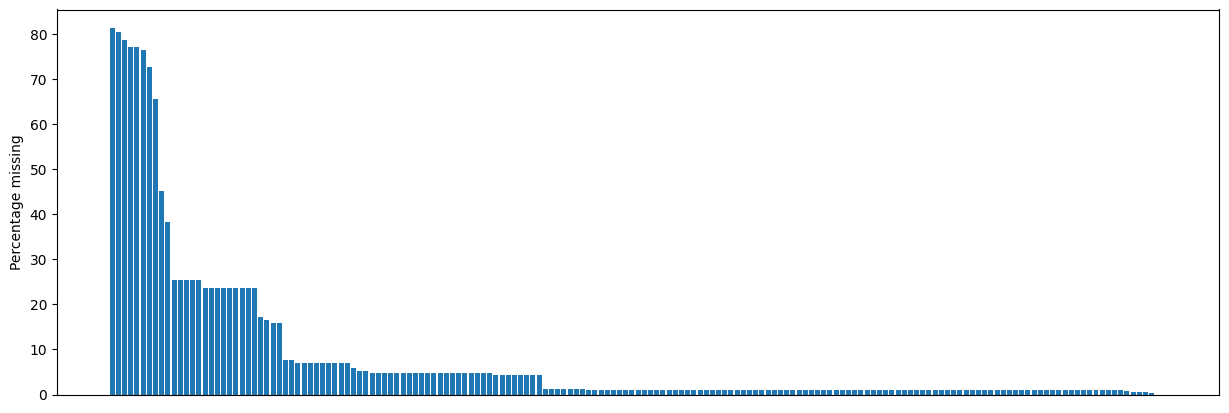

In [5]:
# plotting missing values count for each column
# matplotlib


fig, ax = plt.subplots(figsize=(15,5))

missing = df.isna().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0, ascending=False)

ax.bar(missing.index, missing.values.T[0])
plt.xticks([])
plt.ylabel("Percentage missing")
plt.show()

In [6]:
# plotly  :  missing values count each column


missing = df.isna().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0, ascending=False)

fig = go.Figure(data= go.Bar(x = missing.index, y = missing[0], marker_color='royalblue'))

fig.update_layout(title="Percentage of missing values by column", xaxis_title = "Columns",yaxis_title="Percentage Missing", xaxis_tickangle=45, height=500, width= 1200)
fig.show()

Dropping Columns which has more than 70% of missing values.

In [7]:
dropcols = missing[missing[0] > 70]
dropcols

,0
br_000,81.410965
bq_000,80.501824
bp_000,78.794075
cr_000,77.086327
ab_000,77.086327
bo_000,76.533658
bn_000,72.761689


In [8]:
df.drop(list(dropcols.index), axis=1, inplace=True)

In [9]:
# check dataset shape

df.shape

(36188, 164)

In [10]:
missing_values_count = df.isnull().sum()
total_cells = np.prod(df.shape)
total_missing = missing_values_count.sum()


# percent of data that is missing
print(f"Percentage of total missing cells in the data {(total_missing/total_cells) * 100} %")

Percentage of total missing cells in the data 5.37059852747306 %


Visualization of unique values in target variable

Positive : 1000 , Negative : 35188


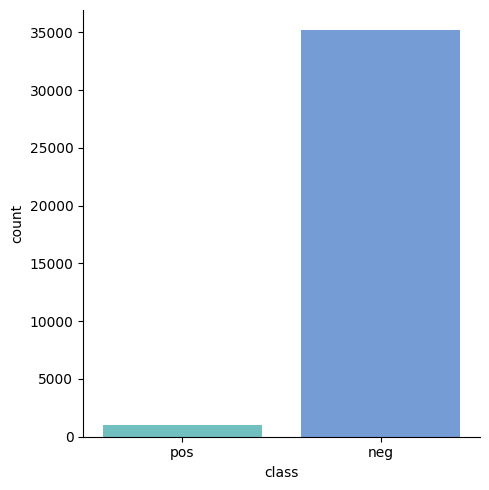

In [11]:
pos = df[df['class']=='pos'].shape[0]
neg = df[df['class']=='neg'].shape[0]
print("Positive : " + str(pos) + " , " +"Negative : " + str(neg))
sns.catplot(data=df, x="class", kind="count", palette="winter_r", alpha=0.6)
plt.show()

**Report**

- The target classes are highly imbalanced
- Class imbalance is a scenario that arises when we have unequal distribution of class in a dataset i.e. the no. of data points in the negative clas (majority class) very large compared to that of the positive class (minority class)
- If the imbalanced data is not treated beforehand, then this will degrade the performance of the classifier model.
- Hence we should handle imbalanced data with cortain methods.


**How to handle Imbalance Data?**

- Resampling data is one of the most commonly preferred approaches to deal with an imbalanced dataset. There are broadly two types of methods for this i) Undersampling ii) Oversampling. In most cases, oversampling is preferred over undersampling techniques. The reason being, in undersampling we tend to remove instances from data that may be carrying some important information.
- SMOTE: Synthetic Minority Oversampling Technique
- SMOTE is an oversampling technique where the synthetic samples are generated for the minority class.
- Hybridization techniques involve combining both undersampling and oversampling techniques. This is done to optimize the performance of classifier models for the samples created as part of these techniques.
- It only duplicates the data and it won't add and new information. Hence we look at some different techniques.

**Create Functions for model training and evaluation**

In [12]:
def evaluate_clf(true, predicted):
    """
    This function takes in true values and predicted values
    Return : Accuracy, F1-Score, Precision, Recall, Roc-auc Score
    """

    acc = accuracy_score(true, predicted)
    f1 = f1_score(true, predicted)
    precision = precision_score(true, predicted)
    recall = recall_score(true, predicted)
    roc_auc = roc_auc_score(true, predicted)
    return acc, f1, precision, recall, roc_auc

In [13]:
# Create cost of the model as per data description


def total_cost(y_true, y_pred):
    """
    This function takes y_true, y_predicted and print total cost due to misclassification
    tn = true negative, fp = false positive , fn = false negative , tp = true positive
    """

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = 10 * fp  +  500 * fn
    return cost

In [14]:
# Create a function which can evaluate models and return a report


def evaluate_models(X, y, models):
    """
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test Split
    Iterates through the given model dictionary and evaluate the metrics
    Return : DataFrame which contains report of all models metrics with cost
    """

    # separate dataset into train and test
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)


    cost_list = []
    models_list = []
    accuracy_list = []

    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train)  # Train Model

        # Make Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1, model_train_precision, model_train_recall, model_train_rocauc_score = evaluate_clf(y_train, y_train_pred)
        train_cost = total_cost(y_train, y_train_pred)

        # Test set performance
        model_test_accuracy, model_test_f1, model_test_precision, model_test_recall, model_test_rocauc_score = evaluate_clf(y_test, y_test_pred)
        test_cost = total_cost(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])


        print("Model Performance for Training set")
        print("- Accuracy :  {:.4f}".format(model_train_accuracy))
        print("- F1 Score : {:.4f}".format(model_train_f1))
        print("- Precision : {:.4f}".format(model_train_precision))
        print("- Recall : {:.4f}".format(model_train_recall))
        print("- Roc Acu Score : {:.4f}".format(model_train_rocauc_score))
        print(f'- COST : {train_cost}.')

        print("--------------------------------")

        print("Model Performance for Test set")
        print("- Accuracy :  {:.4f}".format(model_test_accuracy))
        print("- F1 Score : {:.4f}".format(model_test_f1))
        print("- Precision : {:.4f}".format(model_test_precision))
        print("- Recall : {:.4f}".format(model_test_recall))
        print("- Roc Acu Score : {:.4f}".format(model_test_rocauc_score))
        print(f'- COST : {test_cost}.')
        cost_list.append(test_cost)
        print("="*35)
        print("\n")


    report= pd.DataFrame(list(zip(models_list, cost_list)), columns=['Model_Name', 'Cost']).sort_values(by=["Cost"])
    return report


Plot distribution of all Independent Numerical variables

In [ ]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'object']

plt.figure(figsize=(15,100))

for i,col in enumerate(numeric_features):
    plt.subplot(60,3, i+1)
    sns.displot(x=df[col], color='indianred')
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

    

**Report**

- As per the above plot most of the features are not normally distributed.
- Transformation of data is not of prime importance since it is a classification problem. 
- Interpreting each and every column is not necessary as this is sensor data.

**Evaluate Model on Different Experiments**

In [15]:
# Splitting X and y for all Experiments

X = df.drop('class', axis = 1)
y = df['class']

Manually Encoding Target Variable

In [16]:
y = y.replace({'pos':1, 'neg':0})

**Experiment: 1 = KNN Imputer for Null values**


1 **Why Robust scaler and not Standard scaler?**
- Scaling the data using Robust scaler
- Since most of the independent variables are not normally distributed we cannot use Standard

**Why Robust Scaler and not Minmax?**

- Because most of the feature has outliers. So Minmax will scale data according to Max values which is outlier.
- This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range).
between the 1st quartile(25th quartile) and the 3rd quartila (75th quantile).

In [17]:
# Fit with robust scaler for KNN best K-selection experiment
# fit = value adjsut
# transform = value transform

robustscaler = RobustScaler()
X1 = robustscaler.fit_transform(X)

**Why KNN Imputer?**

- KNNImputer by scikit-leam is a widely used method to impute missing values. It is widely being observed as a replacement for traditional imputation techniques.
- KNNImputer helps to impute missing values present in the observations by finding the nearest neighbors with the Euclidean distance matrix.
- Here we Iterates through different K values and get accuracy and choose best K values.


Finding the optimaln_neighbour value for KNN imputer

In [18]:
results = []

# define imputer

imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
strategies = [str(i) for i in [1,3,5,7,9]]

for s in strategies:
    pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', LogisticRegression())])
    scores = cross_val_score(pipeline, X1, y, scoring='accuracy', cv=2, n_jobs=-1)
    results.append(scores)
    print("n_neighbors = %s || accuracy (%.4f)" % (s, mean(scores)))

n_neighbors = 1 || accuracy (0.7114)
n_neighbors = 3 || accuracy (0.7260)
n_neighbors = 5 || accuracy (0.7035)
n_neighbors = 7 || accuracy (0.7010)
n_neighbors = 9 || accuracy (0.6799)


We can observe n_neighbors=3 able to produce highest accuracy

**Pipeline for KNN Imputer**

In [19]:
num_features = X.select_dtypes(exclude="object").columns

# fit the KNN imputer with selected K-value

knn_pipeline = Pipeline(steps=[
    ['imputer', KNNImputer(n_neighbors=3)],
    ['RobustScaler', RobustScaler()]
])

In [20]:
X_knn = knn_pipeline.fit_transform(X)

**Handling Imbalanced data**

SMOTE+TOMEK is one of such a hybrid technique that aims to clean overlapping data points for each of the classes distributed in sample space.

- This method combines the SMOTE ability to generate synthetic data for minority class and Tomek Links ability to remove the data that are identified as Tomek links from the majority class
- To add new data of minority class

1. Choose random data from the minority class.
2. Calculate the distance between the random data and its k nearest neighbors.
3. Multiply the difference with a random number between 0 and 1, then add the result to the minority class as a synthetic sample
4. Repeat step number 2-3 until the desired proportion of minority class is met.

- To remove the tomek links of the majority class
1. Choose random data from the majority class
2. If the random data's nearest neighbor is the data from the minority class (ie. create the Tomek Link), then remove the Tomek Link.

- This is method instead of adding duplicate data it synthesises the new data based on the already avalialble classes. Hence we choose this as our imputer method for this problem.

In [21]:
from imblearn.combine import SMOTETomek


# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42, sampling_strategy='minority', n_jobs=-1)

# Fit the model to generate the data
X_res, y_res = smt.fit_resample(X_knn, y)

**Initialize Default Models in a dictionary**

In [22]:
# Dictionary which contains models for experiment

models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting" : GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGB Classifier": XGBClassifier(),
    "CatBoost Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier()
}

**Fit KNN Imputed data for models in dictionary**

In [23]:
report_knn = evaluate_models(X_res, y_res, models)

Random Forest
Model Performance for Training set
- Accuracy :  1.0000
- F1 Score : 1.0000
- Precision : 1.0000
- Recall : 1.0000
- Roc Acu Score : 1.0000
- COST : 0.
--------------------------------
Model Performance for Test set
- Accuracy :  0.9929
- F1 Score : 0.9930
- Precision : 0.9892
- Recall : 0.9967
- Roc Acu Score : 0.9929
- COST : 12260.


Decision Tree
Model Performance for Training set
- Accuracy :  1.0000
- F1 Score : 1.0000
- Precision : 1.0000
- Recall : 1.0000
- Roc Acu Score : 1.0000
- COST : 0.
--------------------------------
Model Performance for Test set
- Accuracy :  0.9878
- F1 Score : 0.9879
- Precision : 0.9830
- Recall : 0.9927
- Roc Acu Score : 0.9878
- COST : 26700.


Gradient Boosting
Model Performance for Training set
- Accuracy :  0.9842
- F1 Score : 0.9843
- Precision : 0.9808
- Recall : 0.9877
- Roc Acu Score : 0.9842
- COST : 177430.
--------------------------------
Model Performance for Test set
- Accuracy :  0.9840
- F1 Score : 0.9841
- Precision : 

**Report for KNN Imputed data**

In [24]:
report_knn

,Model_Name,Cost
5,XGB Classifier,5440
6,CatBoost Classifier,10060
0,Random Forest,12260
1,Decision Tree,26700
4,K-Neighbors Classifier,39840
2,Gradient Boosting,44870
7,AdaBoost Classifier,99660
3,Logistic Regression,296390


**Insights**

- For the Experiment 1: Knn imputer has XGBoost classifier as the best Model
- Proceeding with further experiments


**Experiment: 2 = Simple Imputer with Strategy Median**

- Simplelmputer is a class in the sklearn.impute module that can be used to replace missing values in a dataset, using a variety of input strategies
- Here we use Simplelmputer can also be used to impute multiple columns at once by passing in a list of column names. Simplelmputer will then replace missing values in all of the specified columns.

In [25]:
num_features = X.select_dtypes(exclude="object").columns

# Fit the Simple Imputer with strategy median
median_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('RobustScaler', RobustScaler())
])

In [26]:
# fit X with median_pipeline


X_median = median_pipeline.fit_transform(X)

In [27]:
# Resampling the minority class. The strategy can be changed as required.

smt = SMOTETomek(random_state=42, sampling_strategy='minority')

# fit the model to genrate the data.
X_res, y_res = smt.fit_resample(X_median, y)

In [28]:
# Training the models

report_median = evaluate_models(X_res, y_res, models)

Random Forest
Model Performance for Training set
- Accuracy :  1.0000
- F1 Score : 1.0000
- Precision : 1.0000
- Recall : 1.0000
- Roc Acu Score : 1.0000
- COST : 0.
--------------------------------
Model Performance for Test set
- Accuracy :  0.9918
- F1 Score : 0.9919
- Precision : 0.9866
- Recall : 0.9973
- Roc Acu Score : 0.9917
- COST : 10460.


Decision Tree
Model Performance for Training set
- Accuracy :  1.0000
- F1 Score : 1.0000
- Precision : 1.0000
- Recall : 1.0000
- Roc Acu Score : 1.0000
- COST : 0.
--------------------------------
Model Performance for Test set
- Accuracy :  0.9857
- F1 Score : 0.9859
- Precision : 0.9807
- Recall : 0.9911
- Roc Acu Score : 0.9856
- COST : 32880.


Gradient Boosting
Model Performance for Training set
- Accuracy :  0.9840
- F1 Score : 0.9840
- Precision : 0.9813
- Recall : 0.9867
- Roc Acu Score : 0.9840
- COST : 190760.
--------------------------------
Model Performance for Test set
- Accuracy :  0.9810
- F1 Score : 0.9812
- Precision : 

**Report Simple Imputer with median strategy**

In [29]:
report_median

,Model_Name,Cost
5,XGB Classifier,6010
6,CatBoost Classifier,6270
0,Random Forest,10460
1,Decision Tree,32880
2,Gradient Boosting,48240
4,K-Neighbors Classifier,54430
7,AdaBoost Classifier,89540
3,Logistic Regression,305130


**Insights**

- For the Experiments2 : Simple Imputer with median strategy has Catboost classifier as the best model
- Proceeding with further experiments

**Experiment: 3 = MICE for Imputing Null values**

- MICE stands for multivariate imputation by chained equations algorithm
- This technique by which we can effortlesly impute missing values in a dataset by looking at data from other columns and trying to estimate the best prediction for each missing value.
- ImputationKernel Creates a kernel dataset. This dataset can perform MICE on itself, and imputer new data from models obtained during MICE.

In [30]:
import miceforest as mf


X_mice = X.copy()
kernel = mf.ImputationKernel(X_mice, save_all_iterations_data = True, random_state = 1989)    # Run the MICE algorithm for 3 iterations kernel.mice(3)

In [31]:
X_mice = kernel.complete_data()

In [32]:
# fit robust scaler

mice_pipeline = Pipeline(steps=[
    ("RobustScaler", RobustScaler())
])

In [33]:
# fit X with Mice Imputer

X_mice = mice_pipeline.fit_transform(X_mice)

In [34]:
# Resampling the minority class. The strategy can be changed as required.

smt = SMOTETomek(random_state=42, sampling_strategy='minority', n_jobs=-1)

# fit the model to genrate the data
X_res, y_res = smt.fit_resample(X_mice, y)

In [35]:
# Training the models

report_mice = evaluate_models(X_res, y_res, models)

Random Forest
Model Performance for Training set
- Accuracy :  1.0000
- F1 Score : 1.0000
- Precision : 1.0000
- Recall : 1.0000
- Roc Acu Score : 1.0000
- COST : 0.
--------------------------------
Model Performance for Test set
- Accuracy :  0.9888
- F1 Score : 0.9889
- Precision : 0.9827
- Recall : 0.9952
- Roc Acu Score : 0.9888
- COST : 18230.


Decision Tree
Model Performance for Training set
- Accuracy :  1.0000
- F1 Score : 1.0000
- Precision : 1.0000
- Recall : 1.0000
- Roc Acu Score : 1.0000
- COST : 0.
--------------------------------
Model Performance for Test set
- Accuracy :  0.9818
- F1 Score : 0.9819
- Precision : 0.9770
- Recall : 0.9869
- Roc Acu Score : 0.9818
- COST : 47630.


Gradient Boosting
Model Performance for Training set
- Accuracy :  0.9848
- F1 Score : 0.9848
- Precision : 0.9819
- Recall : 0.9878
- Roc Acu Score : 0.9848
- COST : 176600.
--------------------------------
Model Performance for Test set
- Accuracy :  0.9803
- F1 Score : 0.9805
- Precision : 

**Report for MICE Imputer algorithm**

In [36]:
report_mice

,Model_Name,Cost
5,XGB Classifier,9170
6,CatBoost Classifier,15190
0,Random Forest,18230
2,Gradient Boosting,47350
1,Decision Tree,47630
4,K-Neighbors Classifier,54870
7,AdaBoost Classifier,91490
3,Logistic Regression,165760


**Insights**

- For the Experiment 3: Mice imputer has XGBoost classifier as the best model
- Proceeding with further experiments


**Experiment: 4 = Simple Imputer with Strategy Constant**

- Another strategy which can be used is replacing missing values with a fixed (constant)value.
- To do this, specify "constant" for strategy and specify the fill value using fill_value parameter

In [37]:
# Create a pipeline with simple imputer with strategy constant and fill value 0

constant_pipeline = Pipeline(steps=[
    ("IMputer", SimpleImputer(strategy='constant', fill_value=0)),
    ("RobustScaler", RobustScaler())
])

In [38]:
X_const = constant_pipeline.fit_transform(X)

In [39]:
# Resampling the minority class. The strategy can be changed as required.

smt = SMOTETomek(random_state=42, sampling_strategy='minority', n_jobs=-1)

# fit the model to generate the data.

X_res, y_res = smt.fit_resample(X_const, y)

In [40]:
# training the models


report_const = evaluate_models(X_res, y_res, models)

Random Forest
Model Performance for Training set
- Accuracy :  1.0000
- F1 Score : 1.0000
- Precision : 1.0000
- Recall : 1.0000
- Roc Acu Score : 1.0000
- COST : 0.
--------------------------------
Model Performance for Test set
- Accuracy :  0.9932
- F1 Score : 0.9932
- Precision : 0.9898
- Recall : 0.9966
- Roc Acu Score : 0.9931
- COST : 12720.


Decision Tree
Model Performance for Training set
- Accuracy :  1.0000
- F1 Score : 1.0000
- Precision : 1.0000
- Recall : 1.0000
- Roc Acu Score : 1.0000
- COST : 0.
--------------------------------
Model Performance for Test set
- Accuracy :  0.9872
- F1 Score : 0.9874
- Precision : 0.9815
- Recall : 0.9933
- Roc Acu Score : 0.9872
- COST : 24820.


Gradient Boosting
Model Performance for Training set
- Accuracy :  0.9830
- F1 Score : 0.9830
- Precision : 0.9803
- Recall : 0.9857
- Roc Acu Score : 0.9830
- COST : 205550.
--------------------------------
Model Performance for Test set
- Accuracy :  0.9807
- F1 Score : 0.9808
- Precision : 

**Report for Simple Imputer with Constant strategy**

In [41]:
report_const

,Model_Name,Cost
5,XGB Classifier,2440
6,CatBoost Classifier,3970
0,Random Forest,12720
1,Decision Tree,24820
4,K-Neighbors Classifier,43200
2,Gradient Boosting,56120
7,AdaBoost Classifier,92210
3,Logistic Regression,115580


**Insights**

- For the Experiment 4: Simple imputer with constant strategy has XGBoost classifier as the best Model
- Proceeding with further experiments


**Experiment: 5 = Simple Imputer with Strategy Mean**

- Another strategy which can be used is replacing missing values with mean
- Here we replace the missing values with the mean of the column

In [42]:
# # Create a pipeline with Simple imputer with strategy mean

mean_pipeline = Pipeline(steps=[
    ("Imputer", SimpleImputer(strategy='mean')),
    ("RobustScaler", RobustScaler())
])

In [43]:
X_mean = mean_pipeline.fit_transform(X)

In [44]:
# Resampling the minority class. The strategy can be changed as required.


smt = SMOTETomek(random_state=42, sampling_strategy='minority', n_jobs=-1)

# fit the model to generate the data.

X_res, y_res = smt.fit_resample(X_mean, y)

In [45]:
# Training all models

report_mean = evaluate_models(X_res, y_res, models)

Random Forest
Model Performance for Training set
- Accuracy :  1.0000
- F1 Score : 1.0000
- Precision : 1.0000
- Recall : 1.0000
- Roc Acu Score : 1.0000
- COST : 0.
--------------------------------
Model Performance for Test set
- Accuracy :  0.9942
- F1 Score : 0.9942
- Precision : 0.9901
- Recall : 0.9983
- Roc Acu Score : 0.9943
- COST : 6690.


Decision Tree
Model Performance for Training set
- Accuracy :  1.0000
- F1 Score : 1.0000
- Precision : 1.0000
- Recall : 1.0000
- Roc Acu Score : 1.0000
- COST : 0.
--------------------------------
Model Performance for Test set
- Accuracy :  0.9867
- F1 Score : 0.9866
- Precision : 0.9834
- Recall : 0.9898
- Roc Acu Score : 0.9867
- COST : 36660.


Gradient Boosting
Model Performance for Training set
- Accuracy :  0.9856
- F1 Score : 0.9857
- Precision : 0.9828
- Recall : 0.9886
- Roc Acu Score : 0.9856
- COST : 164880.
--------------------------------
Model Performance for Test set
- Accuracy :  0.9864
- F1 Score : 0.9863
- Precision : 0

**Report for Simple imputer with strategy mean**

In [46]:
report_mean

,Model_Name,Cost
5,XGB Classifier,1930
0,Random Forest,6690
6,CatBoost Classifier,7980
1,Decision Tree,36660
2,Gradient Boosting,38660
4,K-Neighbors Classifier,44770
7,AdaBoost Classifier,91120
3,Logistic Regression,306160


**Experiment: 5 = Principle component analysis with imputing median**

- Principal component analysis is a technique for feature extraction — so it combines our input variables in a specific way, then we can drop the “least important” variables while still retaining the most valuable parts of all of the variables!
- As the dataset has 164 columns we can try PCA and check our metrics Cost

In [47]:
from sklearn.decomposition import PCA

In [48]:
pca_pipeline = Pipeline(steps=[
    ("Imputet", SimpleImputer(strategy='constant', fill_value=0)),
    ("RobustScaler", RobustScaler())
])

In [49]:
X_pca = pca_pipeline.fit_transform(X)

In [50]:
# Applying PCA


var_ratio = {}

for i in range(2,150):
    pc = PCA(n_components=i)
    df_pca = pc.fit(X_pca)
    var_ratio[i] = sum(df_pca.explained_variance_ratio_)

**Variance Plot**

<Axes: >

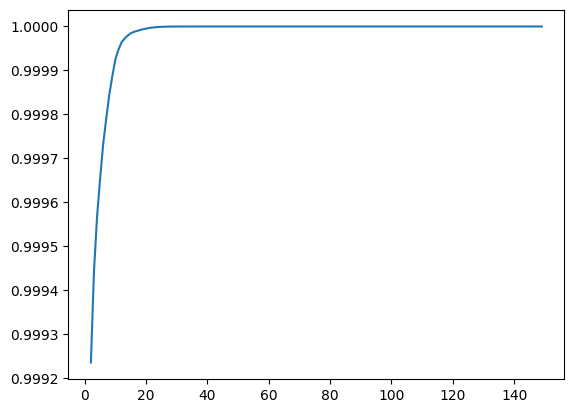

In [51]:
# Plotting variance ratio


pd.Series(var_ratio).plot()

**Kneed algorithm to find the elbow point**

<Figure size 500x500 with 0 Axes>

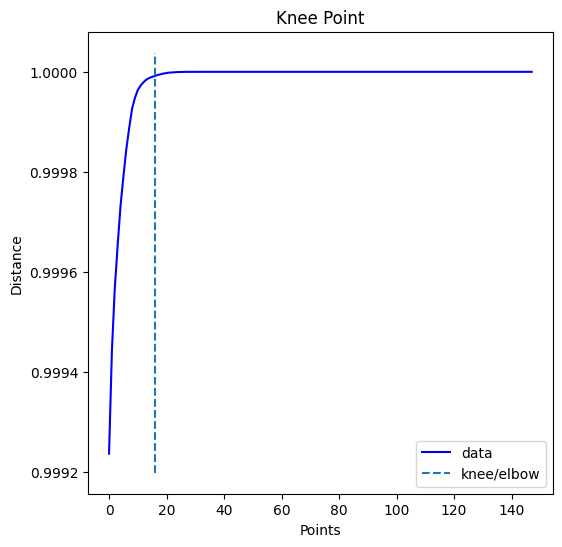

Knee Locator k = 18


In [52]:
from kneed import KneeLocator



i = np.arange(len(var_ratio))
variance_ratio = list(var_ratio.values())
components = list(var_ratio.keys())
knee = KneeLocator(i, variance_ratio, S= 1, curve = 'concave', interp_method = 'polynomial')


fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()
k= components[knee.knee]
print('Knee Locator k =', k)

In [53]:
# Reducing the dimensions of the data 

pca_final = PCA(n_components=18, random_state=42).fit(X_res)

reduced = pca_final.fit_transform(X_pca)

In [54]:
#  Resampling the minority class. The strategy can be changed as required.


smt = SMOTETomek(random_state=42, sampling_strategy='minority', n_jobs=-1)

# fit the model to generate the data.

X_res, y_res = smt.fit_resample(reduced, y)

In [55]:
# Training all models


report_pca = evaluate_models(X_res, y_res, models)

Random Forest
Model Performance for Training set
- Accuracy :  0.9984
- F1 Score : 0.9984
- Precision : 1.0000
- Recall : 0.9969
- Roc Acu Score : 0.9984
- COST : 44000.
--------------------------------
Model Performance for Test set
- Accuracy :  0.9836
- F1 Score : 0.9837
- Precision : 0.9757
- Recall : 0.9917
- Roc Acu Score : 0.9836
- COST : 30720.


Decision Tree
Model Performance for Training set
- Accuracy :  0.9984
- F1 Score : 0.9984
- Precision : 1.0000
- Recall : 0.9969
- Roc Acu Score : 0.9984
- COST : 44000.
--------------------------------
Model Performance for Test set
- Accuracy :  0.9736
- F1 Score : 0.9737
- Precision : 0.9693
- Recall : 0.9781
- Roc Acu Score : 0.9736
- COST : 78660.


Gradient Boosting
Model Performance for Training set
- Accuracy :  0.9417
- F1 Score : 0.9415
- Precision : 0.9455
- Recall : 0.9375
- Roc Acu Score : 0.9417
- COST : 889130.
--------------------------------
Model Performance for Test set
- Accuracy :  0.9399
- F1 Score : 0.9397
- Prec

**Report for PCA and Mean imputed data**

In [56]:
report_pca

,Model_Name,Cost
0,Random Forest,30720
5,XGB Classifier,52370
6,CatBoost Classifier,76460
1,Decision Tree,78660
4,K-Neighbors Classifier,82520
2,Gradient Boosting,222040
7,AdaBoost Classifier,302760
3,Logistic Regression,938630


**Final Model**

In [57]:
from prettytable import PrettyTable

In [65]:
pt = PrettyTable()

pt.field_names = ["Model", "Imputation_method","Total_cost"]
pt.add_row(["XGBClassifier","Simple Imputer-Mean","1930"])
pt.add_row(["XGBClassifier", "Simple Imputer-Constant", "2440"])
pt.add_row(["XGBClassifier","Knn-Imputer","5440"])
pt.add_row(["XGB Classifier","Median","6010"])
pt.add_row(["XGBClassifier", "Mice", "9170"])
pt.add_row(["Random Forest","PCA","30720"])
print(pt)

+----------------+-------------------------+------------+
|     Model      |    Imputation_method    | Total_cost |
+----------------+-------------------------+------------+
| XGBClassifier  |   Simple Imputer-Mean   |    1930    |
| XGBClassifier  | Simple Imputer-Constant |    2440    |
| XGBClassifier  |       Knn-Imputer       |    5440    |
| XGB Classifier |          Median         |    6010    |
| XGBClassifier  |           Mice          |    9170    |
| Random Forest  |           PCA           |   30720    |
+----------------+-------------------------+------------+


**Report**

- From the final report we can see than XGBClassifier with Simple imputer with strategy mean has performed the best with cost of 1930

**Fitting the Final model and get reports**

In [66]:
final_model = XGBClassifier()

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_mean, y)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)

final_model = final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

In [68]:
print("Final XGBoost Classifier Accuracy Score (Train) :", final_model.score(X_train,y_train))
print("Final XGBoost Classifier Accuracy Score (Test) :", accuracy_score(y_pred,y_test))

Final XGBoost Classifier Accuracy Score (Train) : 0.9999821810406272
Final XGBoost Classifier Accuracy Score (Test) : 0.9967213114754099


In [69]:
print("Final XGBoost Classifier Cost Metric(Test) :",total_cost(y_test, y_pred))

Final XGBoost Classifier Cost Metric(Test) : 1930


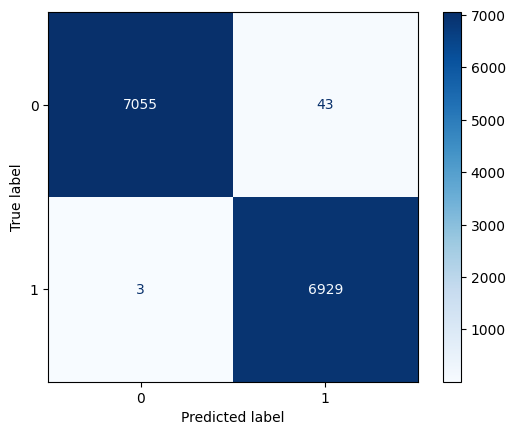

In [70]:
from sklearn.metrics import ConfusionMatrixDisplay

# Display confusion matrix
ConfusionMatrixDisplay.from_estimator(final_model, X_test, y_test, cmap='Blues', values_format='d')


**The best Model is XGBoost Classifier with 99.6% accuracy and cost of 1930**